# Import Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os
from os import path
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import ImageColorGenerator
from PIL import Image

from scipy import stats

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Read in Saved Cleaned Reviews

In [2]:
df_com_train = pd.read_pickle('./Drugs_Com_Training_cleaned.pk')
df_com_test = pd.read_pickle('./Drugs_Com_Testing_cleaned.pk')
drugs_lib_train = pd.read_pickle('./Drugs_Lib_Training_cleaned.pk')
drugs_lib_test = pd.read_pickle('./Drugs_Lib_Testing_cleaned.pk')

df_com_full = pd.read_pickle('./Drugs_Com_Full_cleaned.pk')
df_lib_full = pd.read_pickle('./Drugs_Lib_Full_cleaned.pk')

# Exploratory Data Analysis

## Drugs.com Dataset

Next I check to see if the test set and the training set are similarly distributed. If they are not close to a representative example of each other than attempting to train a classificaton model would not yield accurate results on the test set.

### Unique Values

In [3]:
print("Drugs.com training examples: ", len(df_com_train))
print("Drugs.com testing examples: ", len(df_com_test))
print("Number of unique conditions in training set: ", df_com_train['condition'].nunique())
print("Number of unique conditions in testing set: ", df_com_test['condition'].nunique())
print("Number of unique drugs in training set: ", df_com_train['drugName'].nunique())
print("Number of unique drugs in testing set: ", df_com_test['drugName'].nunique())

Drugs.com training examples:  159498
Drugs.com testing examples:  53200
Number of unique conditions in training set:  811
Number of unique conditions in testing set:  664
Number of unique drugs in training set:  3412
Number of unique drugs in testing set:  2629


### Ratings Distribution

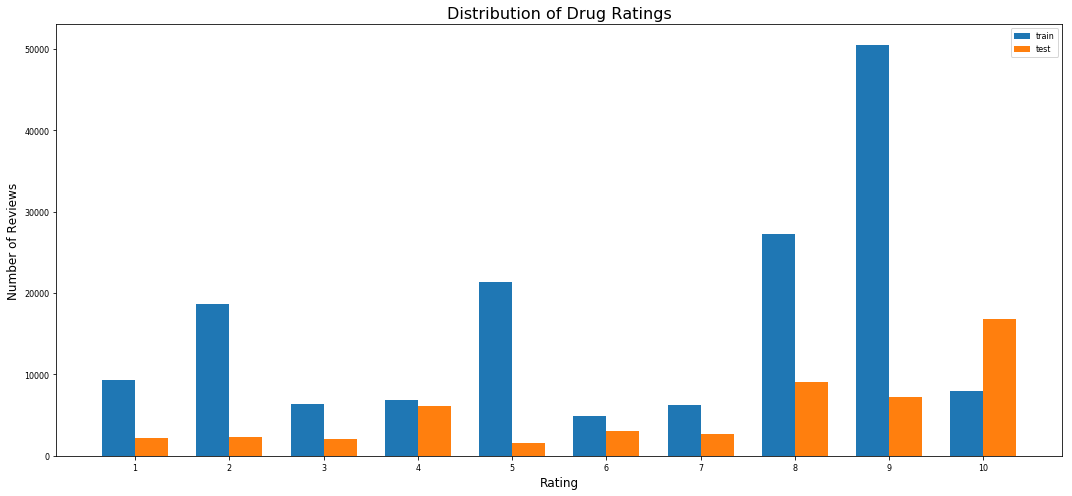

In [4]:
fig, ax = plt.subplots(figsize=(15,7))
width = 0.35
p1 = plt.bar(df_com_train['rating'].unique() - width/2, 
             df_com_train['rating'].value_counts(), width, label = 'train')
plt.title('Distribution of Drug Ratings')
ax.set_ylabel('Number of Reviews')
ax.set_xlabel('Rating')
ax.set_xticks(df_com_train['rating'].unique())

p2 = plt.bar(df_com_test['rating'].unique() + width/2, 
             df_com_test['rating'].value_counts(), width, label = 'test')

ax.legend()
fig.tight_layout()

plt.show()

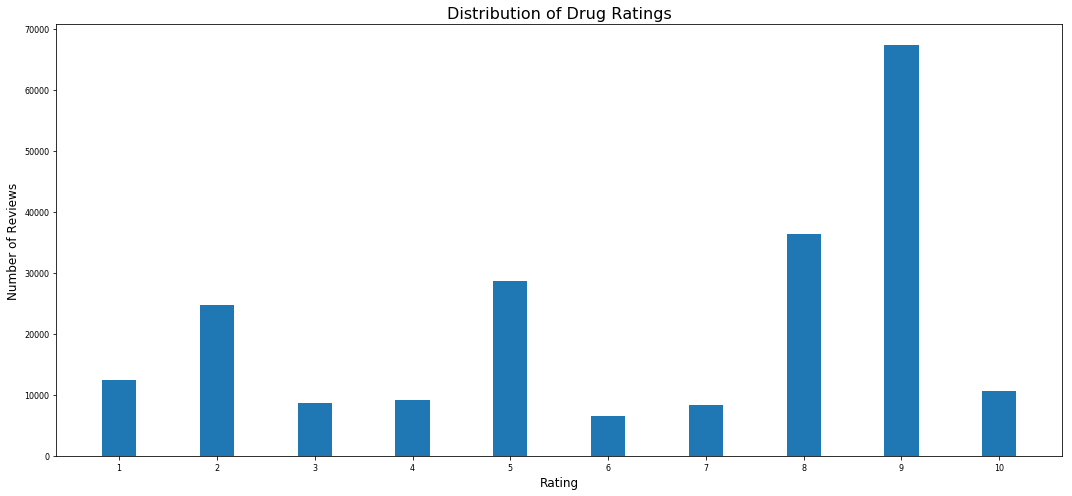

In [5]:
fig, ax = plt.subplots(figsize=(15,7))
width = 0.35
p1 = plt.bar(df_com_full['rating'].unique(), 
             df_com_full['rating'].value_counts(), width)
plt.title('Distribution of Drug Ratings')
ax.set_ylabel('Number of Reviews')
ax.set_xlabel('Rating')
ax.set_xticks(df_com_full['rating'].unique())
fig.tight_layout()
plt.show()

### Top Occuring Conditions & Drugs

In [6]:
def plot_top_conditions(df, title):
    top_vals = 15
    temp = df['condition'].value_counts()
    temp2 = temp.head(top_vals)
    if len(temp) > top_vals:
        temp2['remaining {0} items'.format(len(temp) - top_vals)] = sum(temp[top_vals:])
    ax = temp2.plot(kind='barh', title = 'Top {0} conditions for {1}'.format(top_vals, title))
    ax.set_xlabel('Number of Reviews')
    plt.show()
    return

In [7]:
def plot_top_drugs(df, title):
    top_vals = 15
    temp = df['drugName'].value_counts()
    temp2 = temp.head(top_vals)
    if len(temp) > top_vals:
        temp2['remaining {0} items'.format(len(temp) - top_vals)] = sum(temp[top_vals:])
    ax = temp2.plot(kind='barh', title = 'Top {0} drugs for {1}'.format(top_vals, title))
    ax.set_xlabel('Number of Reviews')
    plt.show()
    return

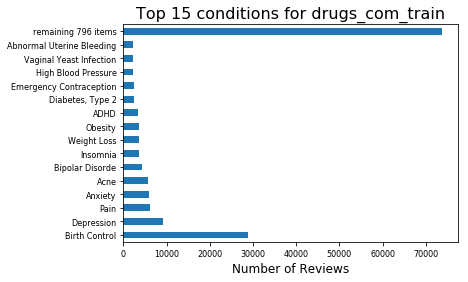

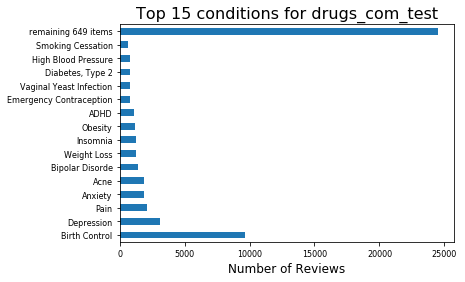

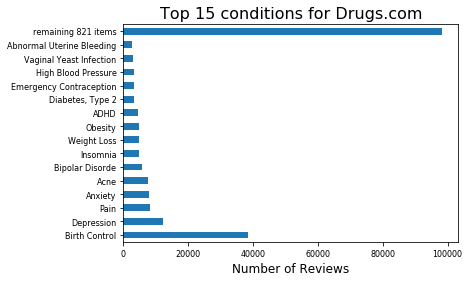

In [8]:
plot_top_conditions(df_com_train, 'drugs_com_train')
plot_top_conditions(df_com_test, 'drugs_com_test')
plot_top_conditions(df_com_full, 'Drugs.com')

The top conditions for both the training and test sets are almost identical with the top six conditions being the exact same and the next nine very similar, although one or two are swapped in position. The top condition is birth control which is almost three times more than the next highest condition of depression. However, there are 649 more conditions listed in the testing dataset and 796 remaining conditions in the training dataset. Therefore, all of the conditions will not necessarily overlap. But some of those may only be listed once. Another problem with the dataset is that the conditions are not all standardized. Some may say "birth prevention" instead of "Birth Control" which skews the results slightly.

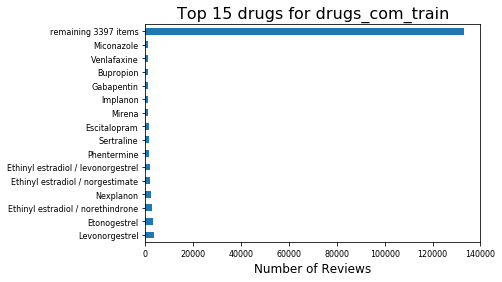

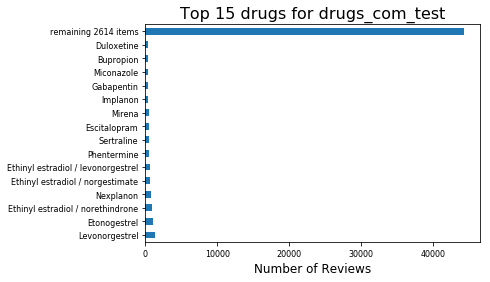

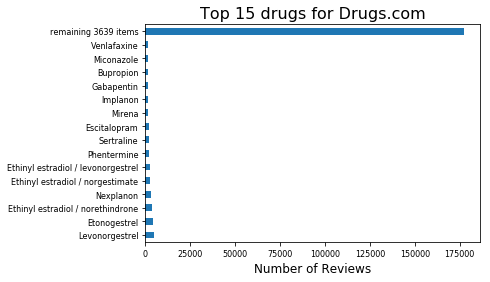

In [9]:
plot_top_drugs(df_com_train, 'drugs_com_train')
plot_top_drugs(df_com_test, 'drugs_com_test')
plot_top_drugs(df_com_full, 'Drugs.com')

When making similar plots for the top drug types being prescribed, the results show that the top six drugs in both testing and training sets are pills for birth control. However, there are many, many more types of unique drugs (thousands in each set) than there are conditions. Some of the drugs suffer similar issues of non-standarization as well. For instance one brand name for Levonorgestrel is Plan B which also shows up as a drug name in the dataset. 

### Review Lengths

In [10]:
df_com_train['Word_Count'] = df_com_train['review'].str.split().str.len()
df_com_test['Word_Count'] = df_com_test['review'].str.split().str.len()
df_com_full['Word_Count'] = df_com_full['review'].str.split().str.len()

print(df_com_train['Word_Count'].describe())
print(df_com_test['Word_Count'].describe())
print(df_com_full['Word_Count'].describe())

count    159498.000000
mean         84.746768
std          45.084358
min           1.000000
25%          48.000000
50%          84.000000
75%         126.000000
max        1894.000000
Name: Word_Count, dtype: float64
count    53200.000000
mean        84.691673
std         44.278294
min          1.000000
25%         48.000000
50%         84.000000
75%        126.000000
max       1162.000000
Name: Word_Count, dtype: float64
count    212698.000000
mean         84.732988
std          44.884006
min           1.000000
25%          48.000000
50%          84.000000
75%         126.000000
max        1894.000000
Name: Word_Count, dtype: float64


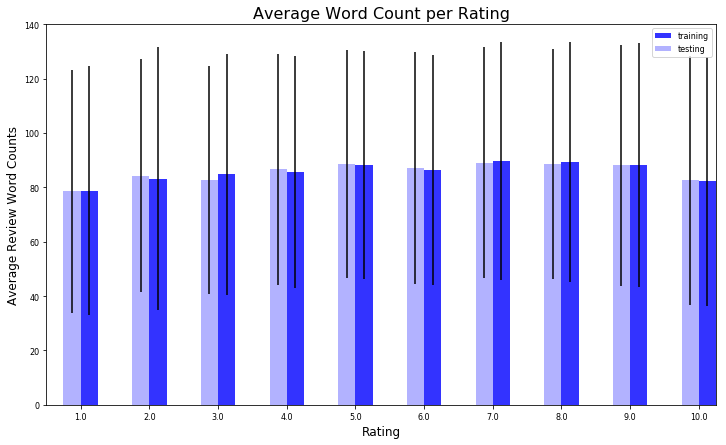

In [11]:
new_tr = df_com_train['Word_Count'].groupby(df_com_train['rating']).mean()
new_tst = df_com_test['Word_Count'].groupby(df_com_test['rating']).mean()

new_tr_std = df_com_train['Word_Count'].groupby(df_com_train['rating']).std()
new_tst_std = df_com_test['Word_Count'].groupby(df_com_test['rating']).std()

fig, ax = plt.subplots(figsize=(12,7))
new_tr.plot(ax=ax, kind='bar', position=0, 
            color='blue', alpha=0.8, label='training', 
            width = 0.25, rot=0, yerr=new_tr_std)
new_tst.plot(ax=ax, kind='bar', position=1, 
             color='blue', alpha=0.3, label='testing', 
             width = 0.25, rot=0, yerr=new_tst_std)
plt.title('Average Word Count per Rating')
plt.legend()

ax.set_ylabel('Average Review Word Counts')
ax.set_xlabel('Rating')

plt.show()

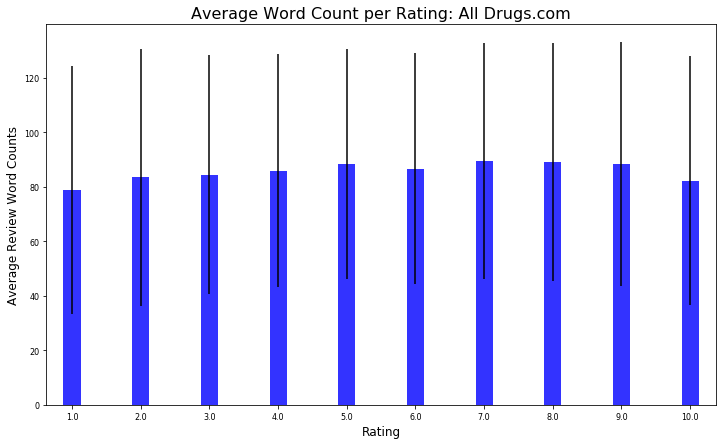

In [12]:
new_full = df_com_full['Word_Count'].groupby(df_com_full['rating']).mean()
new_full_std = df_com_full['Word_Count'].groupby(df_com_full['rating']).std()

fig, ax = plt.subplots(figsize=(12,7))
new_full.plot(ax=ax, kind='bar', color='blue', alpha=0.8, width = 0.25, rot=0, yerr=new_full_std)
plt.title('Average Word Count per Rating: All Drugs.com')
ax.set_ylabel('Average Review Word Counts')
ax.set_xlabel('Rating')

plt.show()

The training and testing sets show that the average word length is relatively constant for each rating. This is especially true because the error bars, the standard deviation of the number of words per review, are so large. Users giving a 1 rating use just barely slightly less words overall and users who give an 8 rating use slightly more words overall.

The above plots show that the testing and training sets are fairly similarly distributed so there is no need to continue to create separate plots for each set. The following graphs will use the testing and training sets combined.

### Investigate for Correlated Variables

With all of the numeric fields I will test to see if there are any correlations in the dataset.

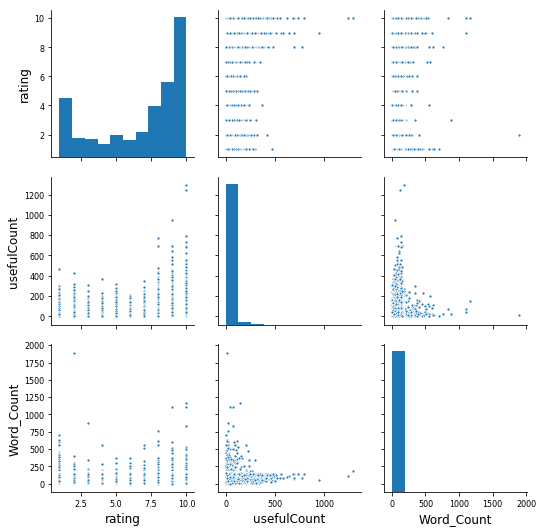

In [13]:
sns.pairplot(df_com_full.drop(df_com_full.columns[0], axis=1), markers=['.'])
plt.show()

The distributions and pairplots do not show any obvious correlations. For the ratings, there are many more reviews that are higher than are given lower scores (besides the lowest of 1). This makes sense because people will often be happy with a drug because it is helping their condition some. If the drug doesn't help the condition, then they are likely to give it the lowest score of 1 instead of a 2, 3, or 4. The usefulCount and Word_Count variables follow similar distributions to the ratings one, probably based solely on the number of reviews in each of the ratings bins.

### Usefulness Distributions

In the Drugs.com dataset there is also a category for usefulness count. This is the number of times a person browsing Drugs.com found the review to be helpful. One method of trying to build a classifier would be to set a cutoff limit for the reviews which have a usefulCount greater than some minimum value. This would help to filter out words that are less helpful in reviews such as 'it was good' as opposed to more detailed versions that could include benefits and side effects.

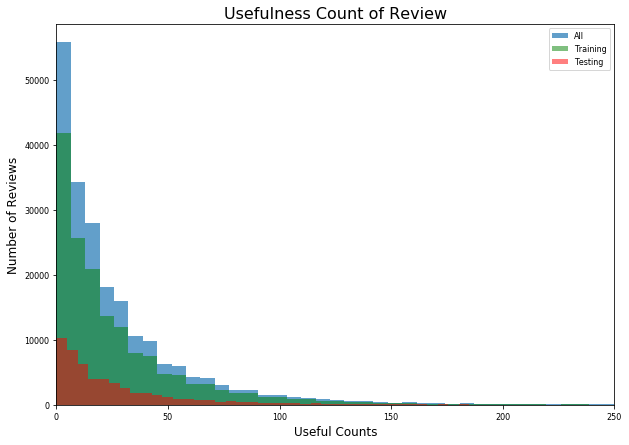

In [14]:
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(df_com_full['usefulCount'], bins=200, alpha=0.7, label='All')
ax.hist(df_com_train['usefulCount'], alpha=0.5, color='green', bins=200, label='Training')
ax.hist(df_com_test['usefulCount'], alpha=0.5, color='red', bins=200, label='Testing')
ax.set(xlim=(0,250), ylabel='Number of Reviews', xlabel='Useful Counts', title='Usefulness Count of Review')
ax.legend()
plt.show()

From the above graph, it looks like the majority of the reviews have few usefulCounts. This may be because of the shear number of reviews, that everyone can't read everything. This possibly could show that the Drugs.com site posts reviews that are the most useful first and so they are the first ones read and continue to get more counts. Setting a minimum usefulCount to 5 would eliminate about 50,000 reviews from the dataset. This would also speed up training time for the classifier.

One hypothesis I had was that reviews with a larger number of words would have the highest usefulCount. I will use a regression plot to see if this is true.

C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


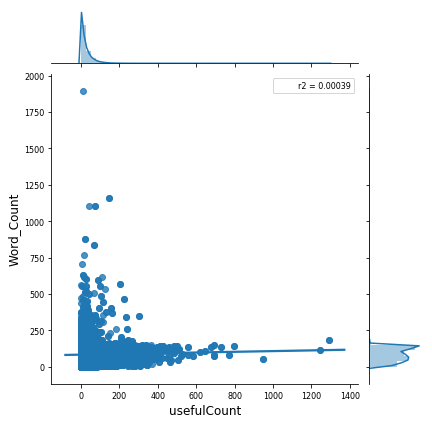

In [15]:
# code example from here: https://stackoverflow.com/questions/25579227/seaborn-implot-with-equation-and-r2-text
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
sns.jointplot('usefulCount', 'Word_Count', data=df_com_full, kind='reg', stat_func=r2)
plt.show()

The above plot shows that there is not a linear relationship between the number of words and the usefulCount, with the r-squared value equal to 0.4%.

### Ratings by Year

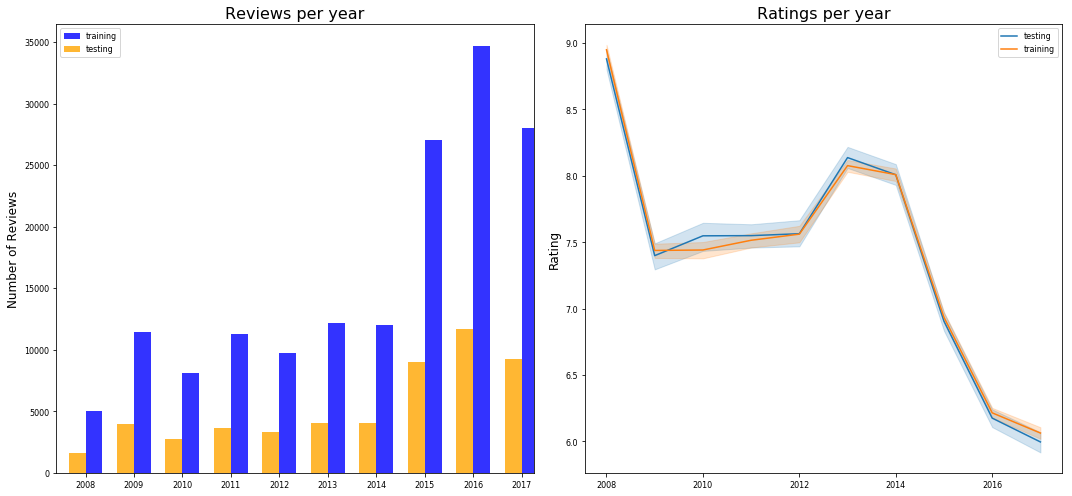

In [16]:
rev_by_yr_tr = df_com_train['date'].groupby([df_com_train['date'].dt.year]).count()
rev_by_yr_tst = df_com_test['date'].groupby([df_com_test['date'].dt.year]).count()

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

rev_by_yr_tr.plot(ax=ax[0], kind='bar', position=0, color='blue', alpha=0.8, label='training', width = 0.35, rot=0)
rev_by_yr_tst.plot(ax=ax[0], kind='bar', position=1, color='orange', alpha=0.8, label='testing', width = 0.35, rot=0)

sns.lineplot(x=df_com_test.date.dt.year, y=df_com_test.rating, data=df_com_train,
             ax=ax[1], label='testing')
sns.lineplot(x=df_com_train.date.dt.year, y=df_com_train.rating, data=df_com_train,
             ax=ax[1], label='training')

ax[0].legend()
ax[1].legend()
ax[0].set_title('Reviews per year')
ax[1].set_title('Ratings per year')
ax[0].set_ylabel('Number of Reviews')
ax[1].set_ylabel('Rating')
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)

fig.tight_layout()
plt.show()

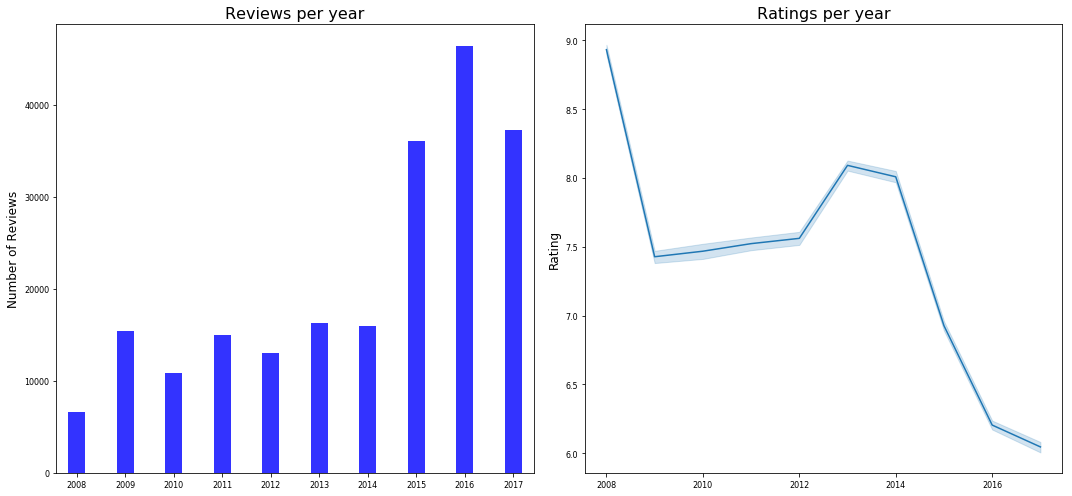

In [17]:
rev_by_yr_full = df_com_full['date'].groupby([df_com_full['date'].dt.year]).count()

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

rev_by_yr_full.plot(ax=ax[0], kind='bar', color='blue', alpha=0.8, width = 0.35, rot=0)
sns.lineplot(x=df_com_full.date.dt.year, y=df_com_full.rating, data=df_com_full, ax=ax[1])

ax[0].set_title('Reviews per year')
ax[1].set_title('Ratings per year')
ax[0].set_ylabel('Number of Reviews')
ax[1].set_ylabel('Rating')
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)

fig.tight_layout()
plt.show()

Only the Drugs.com dataset contains the date of the review, so it cannot be compared to the second source. However, It does show that the total number of reviews has increased throughout the years. It was fairly steady for the years 2009-2014, but then reviews almost doubled from 2014 to 2015 and continued to climb. Only partial data from 2017 was collected so if the entire year was to be counted then the reviews probably would have surpassed 2016.

The plot on the right shows that as the years have progressed, the average rating for a review has decreased from about 9 to closer to 6. People seem to be more discontent with the drugs they are taking. 

For both graphs, the test and training sets follow each other almost perfectly so the data is very evenly stratified between the two sets.

### Wordclouds

In [18]:
def make_wordcloud(tokens):
        
    # create figure
    fig, ax = plt.subplots(figsize=(12,7))

    # get image outline
    d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
    pill = np.array(Image.open(path.join(d, "pill_rb.png"))) 
 
    # generate wordcloud
    wc = wordcloud.WordCloud(background_color="white", max_words=100, mask=pill, 
                             max_font_size=90, random_state=42).generate(str(tokens))

    # create coloring from image
    image_colors = ImageColorGenerator(pill) 
    plt.imshow(wc.recolor(color_func=image_colors), interpolation="spline36")
    wc.recolor(color_func=image_colors)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return

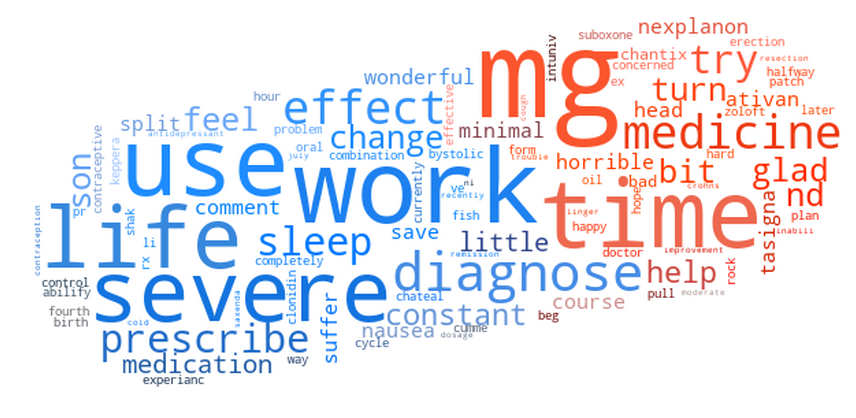

In [19]:
make_wordcloud(df_com_full['review_tokens'])

## Drugs Lib Dataset

### Unique Values

In [20]:
print("Drug Lib training examples: ", len(drugs_lib_train))
print("Drug Lib testing examples: ", len(drugs_lib_test))
print("Number of unique conditions in training set: ", drugs_lib_train['condition'].nunique())
print("Number of unique conditions in testing set: ", drugs_lib_test['condition'].nunique())
print("Number of unique drugs in training set: ", drugs_lib_train['urlDrugName'].nunique())
print("Number of unique drugs in testing set: ", drugs_lib_test['urlDrugName'].nunique())

Drug Lib training examples:  3096
Drug Lib testing examples:  1036
Number of unique conditions in training set:  1422
Number of unique conditions in testing set:  566
Number of unique drugs in training set:  501
Number of unique drugs in testing set:  314


In [21]:
print("Drug Lib all examples: ", len(df_lib_full))
print("Number of unique conditions in entire set: ", df_lib_full['condition'].nunique())
print("Number of unique drugs in entire set: ", df_lib_full['urlDrugName'].nunique())

Drug Lib all examples:  4132
Number of unique conditions in entire set:  1804
Number of unique drugs in entire set:  540


### Ratings Distribution

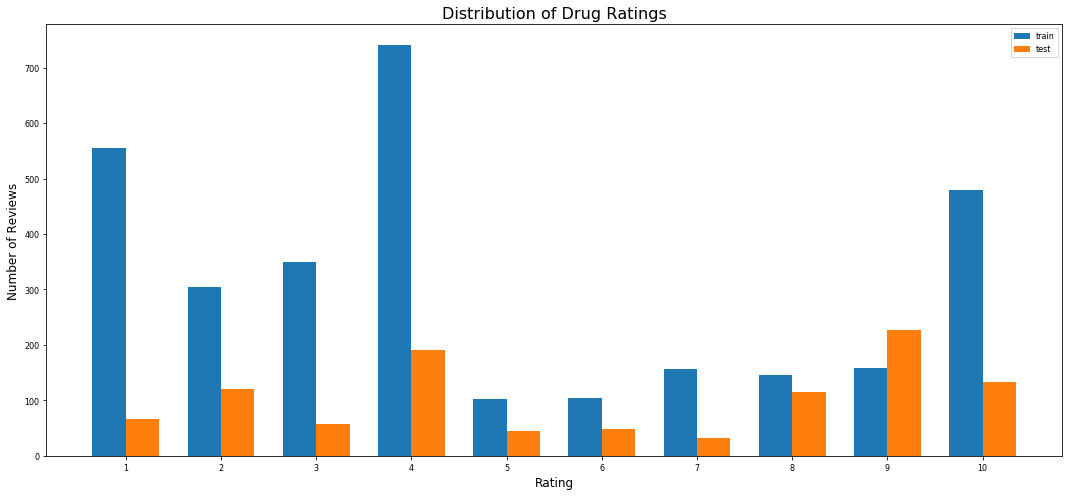

In [22]:
fig, ax = plt.subplots(figsize=(15,7))
width = 0.35
p1 = plt.bar(drugs_lib_train['rating'].unique() - width/2, 
             drugs_lib_train['rating'].value_counts(), width, label = 'train')
plt.title('Distribution of Drug Ratings')
ax.set_ylabel('Number of Reviews')
ax.set_xlabel('Rating')
ax.set_xticks(drugs_lib_train['rating'].unique())

p2 = plt.bar(drugs_lib_test['rating'].unique() + width/2, 
             drugs_lib_test['rating'].value_counts(), width, label = 'test')

ax.legend()
fig.tight_layout()

plt.show()

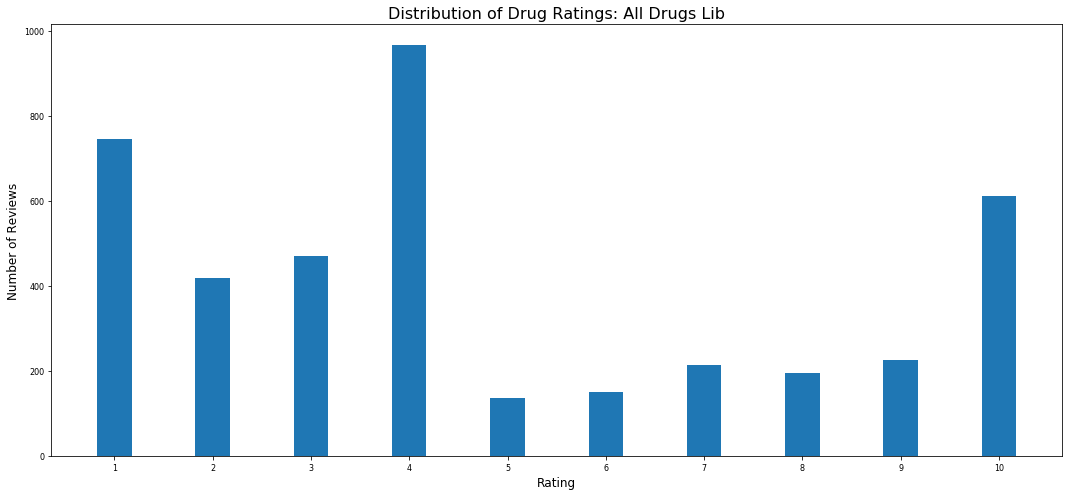

In [23]:
fig, ax = plt.subplots(figsize=(15,7))
width = 0.35
p1 = plt.bar(df_lib_full['rating'].unique(), 
             df_lib_full['rating'].value_counts(), width)
plt.title('Distribution of Drug Ratings: All Drugs Lib')
ax.set_ylabel('Number of Reviews')
ax.set_xlabel('Rating')
ax.set_xticks(df_lib_full['rating'].unique())

fig.tight_layout()
plt.show()

### Top Occuring Conditions & Drugs

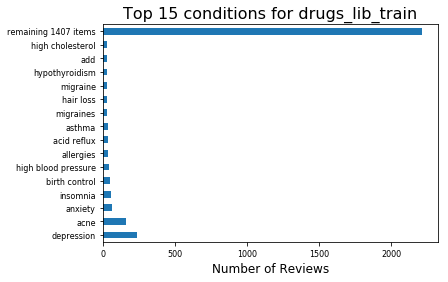

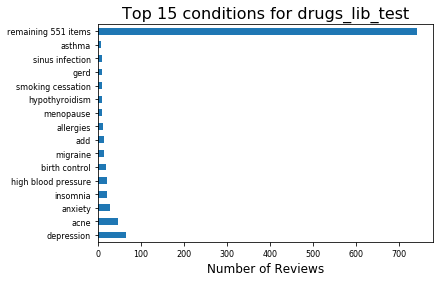

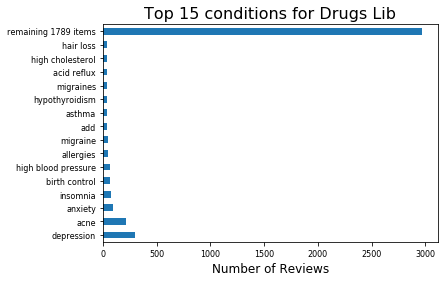

In [24]:
plot_top_conditions(drugs_lib_train, 'drugs_lib_train')
plot_top_conditions(drugs_lib_test, 'drugs_lib_test')
plot_top_conditions(df_lib_full, 'Drugs Lib')

The above plots show that for the Lib dataset depression, acne, anxiety, and insomnia are among the top conditions. Birth control is still in the list of top conditions, however it occurs much less than in the Com dataset. This dataset also has many unique conditions and suffers from non-standardized text.

In [25]:
def plot_top_drugs2(df, title):
    top_vals = 15
    temp = df['urlDrugName'].value_counts()
    temp2 = temp.head(top_vals)
    if len(temp) > top_vals:
        temp2['remaining {0} items'.format(len(temp) - top_vals)] = sum(temp[top_vals:])
    ax = temp2.plot(kind='barh', title = 'Top {0} drugs for {1}'.format(top_vals, title))
    ax.set_xlabel('Number of Reviews')
    plt.show()
    return

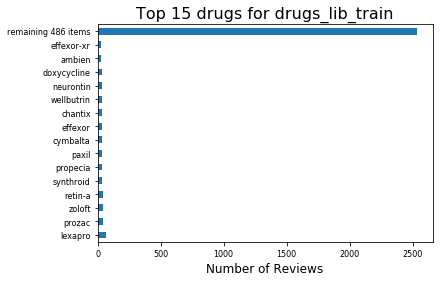

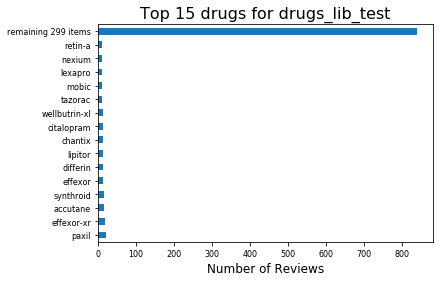

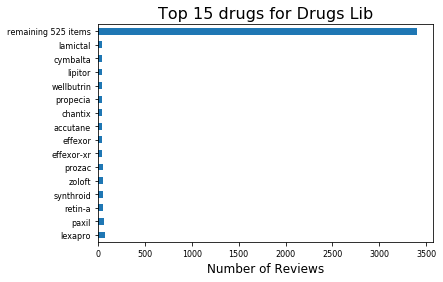

In [26]:
plot_top_drugs2(drugs_lib_train, 'drugs_lib_train')
plot_top_drugs2(drugs_lib_test, 'drugs_lib_test')
plot_top_drugs2(df_lib_full, 'Drugs Lib')

Again, the top drugs correspond to the top occuring conditions, paxil, lexapro, zoloft, and prozac all are for depression and anxiety issues. At first glance, it looks like it is more common for this dataset to use the brand name rather than the generic drug name as opposed to how the Com dataset displayed.

### Review Lengths

In [27]:
drugs_lib_train['b_Word_Count'] = drugs_lib_train['benefitsReview'].str.split().str.len()
drugs_lib_test['b_Word_Count'] = drugs_lib_test['benefitsReview'].str.split().str.len()
df_lib_full['b_Word_Count'] = df_lib_full['benefitsReview'].str.split().str.len()

drugs_lib_train['se_Word_Count'] = drugs_lib_train['sideEffectsReview'].str.split().str.len()
drugs_lib_test['se_Word_Count'] = drugs_lib_test['sideEffectsReview'].str.split().str.len()
df_lib_full['se_Word_Count'] = df_lib_full['sideEffectsReview'].str.split().str.len()

drugs_lib_train['c_Word_Count'] = drugs_lib_train['commentsReview'].str.split().str.len()
drugs_lib_test['c_Word_Count'] = drugs_lib_test['commentsReview'].str.split().str.len()
df_lib_full['c_Word_Count'] = df_lib_full['commentsReview'].str.split().str.len()

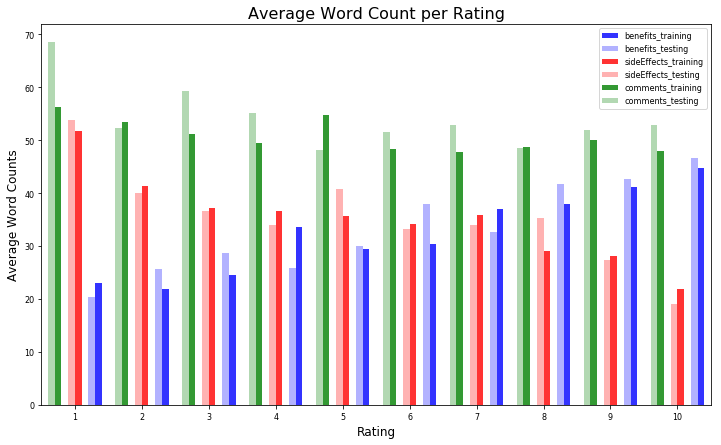

In [28]:
tr1 = drugs_lib_train['b_Word_Count'].groupby(drugs_lib_train['rating']).mean()
tst1 = drugs_lib_test['b_Word_Count'].groupby(drugs_lib_test['rating']).mean()
tr2 = drugs_lib_train['se_Word_Count'].groupby(drugs_lib_train['rating']).mean()
tst2 = drugs_lib_test['se_Word_Count'].groupby(drugs_lib_test['rating']).mean()
tr3 = drugs_lib_train['c_Word_Count'].groupby(drugs_lib_train['rating']).mean()
tst3 = drugs_lib_test['c_Word_Count'].groupby(drugs_lib_test['rating']).mean()

tr1_std = drugs_lib_train['b_Word_Count'].groupby(drugs_lib_train['rating']).std()
tst1_std = drugs_lib_test['b_Word_Count'].groupby(drugs_lib_test['rating']).std()
tr2_std = drugs_lib_train['se_Word_Count'].groupby(drugs_lib_train['rating']).std()
tst2_std = drugs_lib_test['se_Word_Count'].groupby(drugs_lib_test['rating']).std()
tr3_std = drugs_lib_train['c_Word_Count'].groupby(drugs_lib_train['rating']).std()
tst3_std = drugs_lib_test['c_Word_Count'].groupby(drugs_lib_test['rating']).std()

fig, ax = plt.subplots(figsize=(12,7))

tr1.plot(ax=ax, kind='bar', position=-3, color='blue', alpha=0.8, label='benefits_training', width = 0.1, rot=0)
tst1.plot(ax=ax, kind='bar', position=-2, color='blue', alpha=0.3, label='benefits_testing', width = 0.1, rot=0)
         
tr2.plot(ax=ax, kind='bar', position=-0, color='red', alpha=0.8, label='sideEffects_training', width = 0.1, rot=0)
tst2.plot(ax=ax, kind='bar', position=1, color='red', alpha=0.3, label='sideEffects_testing', width = 0.1, rot=0)
         
tr3.plot(ax=ax, kind='bar', position=3, color='green', alpha=0.8, label='comments_training', width = 0.1, rot=0)
tst3.plot(ax=ax, kind='bar', position=4, color='green', alpha=0.3, label='comments_testing', width = 0.1, rot=0)

plt.title('Average Word Count per Rating')
plt.legend()

ax.set_xlim(-0.5,9.5)
ax.set_ylabel('Average Word Counts')
ax.set_xlabel('Rating')

plt.show()

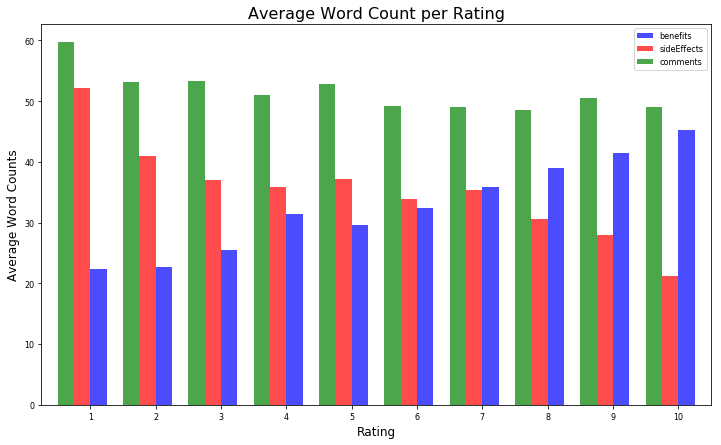

In [35]:
b1 = df_lib_full['b_Word_Count'].groupby(df_lib_full['rating']).mean()
b2 = df_lib_full['se_Word_Count'].groupby(df_lib_full['rating']).mean()
b3 = df_lib_full['c_Word_Count'].groupby(df_lib_full['rating']).mean()

b1_std = df_lib_full['b_Word_Count'].groupby(df_lib_full['rating']).std()
b2_std = df_lib_full['se_Word_Count'].groupby(df_lib_full['rating']).std()
b3_std = df_lib_full['c_Word_Count'].groupby(df_lib_full['rating']).std()

fig, ax = plt.subplots(figsize=(12,7))

b1.plot(ax=ax, kind='bar', position=0, color='blue', alpha=0.7, label='benefits', width = 0.25, rot=0)       
b2.plot(ax=ax, kind='bar', position=1, color='red', alpha=0.7, label='sideEffects', width = 0.25, rot=0)        
b3.plot(ax=ax, kind='bar', position=2, color='green', alpha=0.7, label='comments', width = 0.25, rot=0)

plt.title('Average Word Count per Rating')
plt.legend()

ax.set_xlim(-.75,9.5)
ax.set_ylabel('Average Word Counts')
ax.set_xlabel('Rating')

plt.show()

The above plots shows that the length of the reviews between the testing and training sets are fairly consistent. Also, there is a consistency between the average length of the general comments for each of the different ratings given. However, the benefits and side effects reviews show an inverse relationship. As the average length of the side effects reviews increases, the rating gets worse. Inversly, as the average length of the benefits review increases the rating gets better. This intuitively makes sense because people will be more displeased with a drug as the side effects take a toll on their lives. If the benefits outweigh the side effects than people will be much happier that the drug has fixed or improved their health condition.

Also, all of the above graphs show that the testing and training sets are fairly similarly distributed so there is no need to create separate plots for both datasets anymore. The remaining data analytics will represent the testing and training datasets combined.

### Side Effects Distributions

The Drugslib.com dataset has two unique columns that the Drugs.com dataset lacks. These are Effectiveness and Severity of Side Effects. I will look at the distribution of these fields using bar plots. 

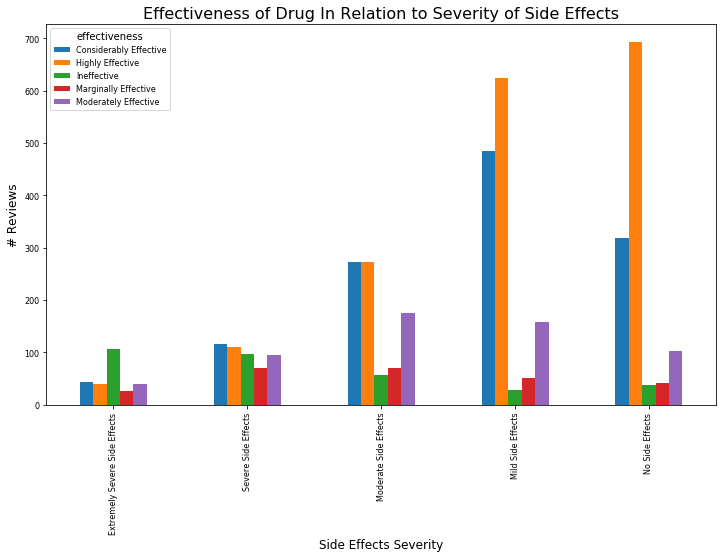

In [30]:
se_order=['Extremely Severe Side Effects', 'Severe Side Effects', 
          'Moderate Side Effects', 'Mild Side Effects', 'No Side Effects']
fig, ax = plt.subplots(figsize=(12,7))
eff_se_grp = df_lib_full.groupby('sideEffects')['effectiveness'].value_counts()
eff_se_grp.unstack().reindex(se_order).plot(kind='bar', ax=ax)
ax.set(title='Effectiveness of Drug In Relation to Severity of Side Effects', 
       xlabel='Side Effects Severity', 
       ylabel='# Reviews')
plt.show()

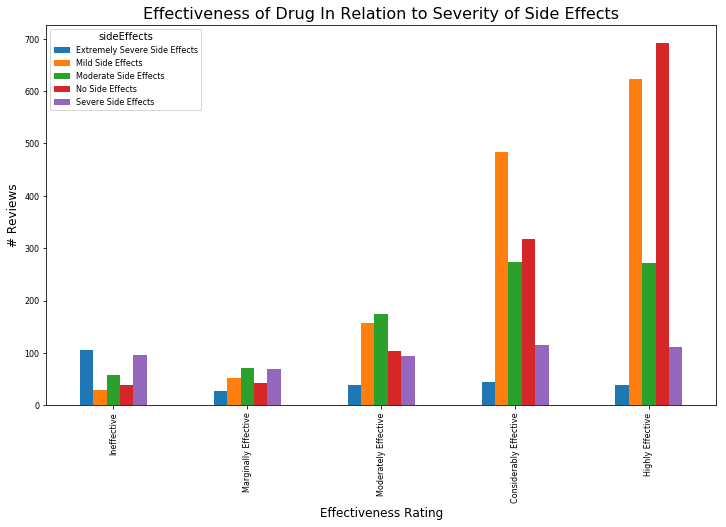

In [31]:
eff_order = ['Ineffective', 'Marginally Effective', 'Moderately Effective',
             'Considerably Effective', 'Highly Effective']
fig, ax = plt.subplots(figsize=(12,7))
eff_se_grp = df_lib_full.groupby('effectiveness')['sideEffects'].value_counts()
eff_se_grp.unstack().reindex(eff_order).plot(kind='bar', ax=ax)
ax.set(title='Effectiveness of Drug In Relation to Severity of Side Effects', 
       xlabel='Effectiveness Rating', 
       ylabel='# Reviews')
plt.show()

Both of the above plots show that the vast majority of revies are for drugs that are Highly Effective and have Mild or No Side Effects. One good thing to note is that the bar with the largest count of reviews is for Highly Effective drugs that have No Side Effects. However, on the other had one scary thing to note is that column that has the highest number of reviews for Extremely Severe Side Effects are for drugs that are Ineffective. That means people are not getting any help with the original condition and are suffering even more from an onset of more issues. It might be beneficial for the pharmacovigilance part of this study to pinpoint that specific group of reviews to make the drug better.

### Wordclouds

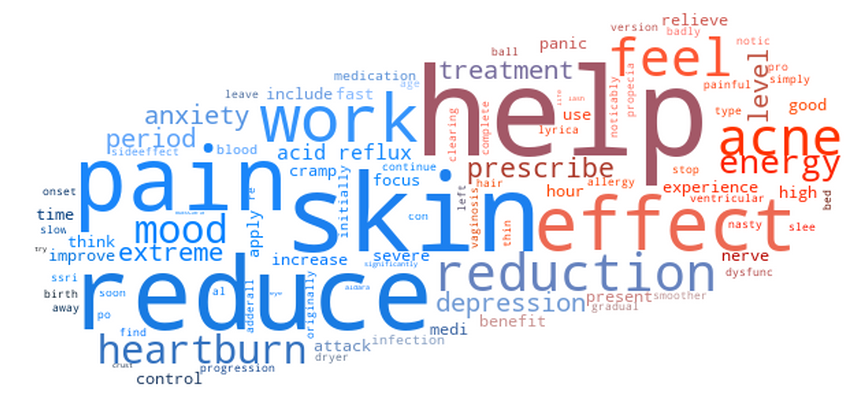

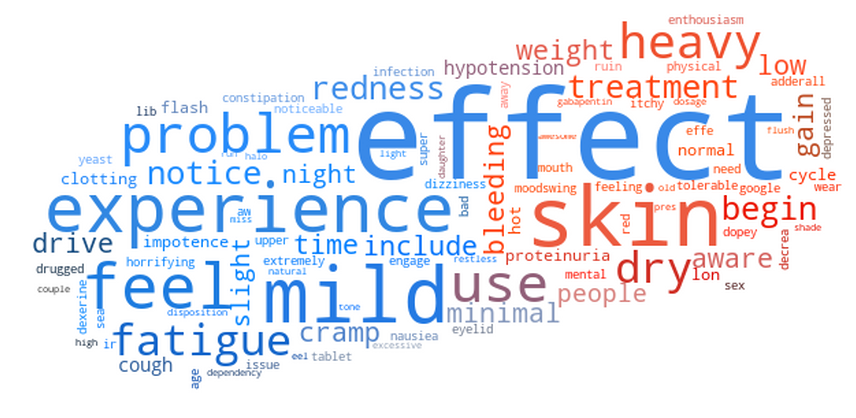

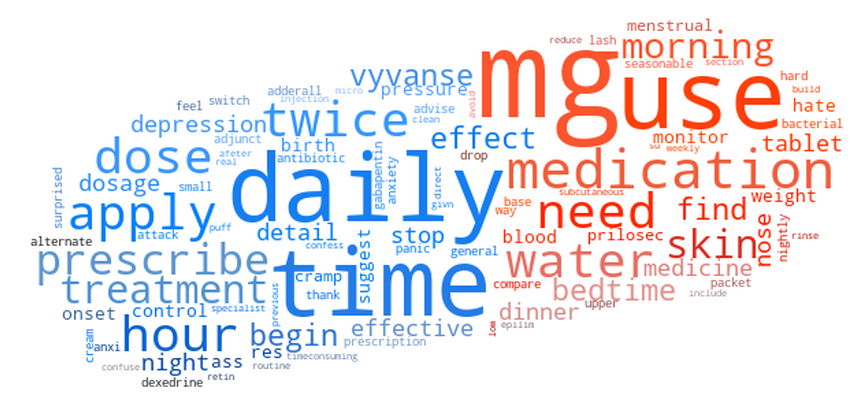

In [32]:
make_wordcloud(df_lib_full['benefits_tokens'])
make_wordcloud(df_lib_full['sideEffects_tokens'])
make_wordcloud(df_lib_full['coments_tokens'])